In [1]:
import astroML
import numpy as np
from scipy      import interpolate
from matplotlib import pyplot      as plt
from astroML.datasets import fetch_dr7_quasar

In [2]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# Select the first 10000 points
data = data[:10000]

z = data['redshift']

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

Text(0.5, 1.0, 'Distribution of quasar redshifts')

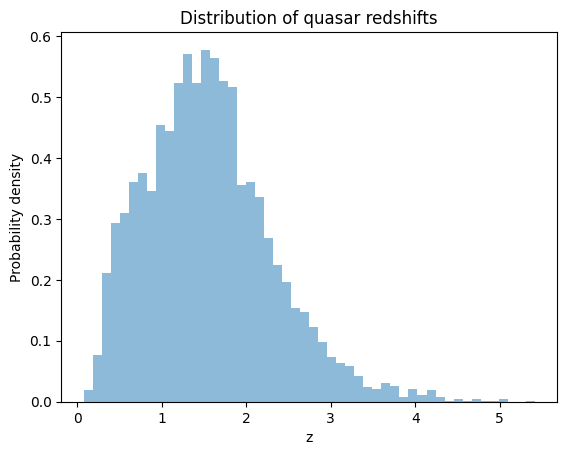

In [3]:
bins = 50
matrice = plt.hist(z, bins=bins, density=True, alpha=0.5) 
plt.ylabel('Probability density')
plt.xlabel('z')
plt.title('Distribution of quasar redshifts')

# Rejection sampling

I want to upsample the quasar redshift distribution with **rejection sampling**. <br>
I want to generate $N=10^4$ points in total. <br>
To do that, I first create a proposal distribution high enough to encompass the tails of the redshift distribution. <br>
I will use a uniform distribution from the minimum to the maximum of the z range, and generate a random point **x** from it. <br>
Then, I generate a random sample **u** from a uniform distribution in the range $[0,h(x)]$. Where $h(x)$ is the redshift distribution. <br>
Finally, for each pair of $(x_i,u_i)$, I will accept only the ones with $u_i<h(x_i)$. <br>
So, since I only know the histogram, I need to verify in which bin is $x_i$ and take the count of that bin as $h(x_i)$.

In [4]:
# I want N = 10^4 accepted samples in total

N_samples = 10**4

sampling_x  = []
sampling_y  = []
rejected_x  = []
rejected_y  = []

i = 0
while i < N_samples:
    
    x = np.random.uniform(min(z),max(z))
    u = np.random.uniform(0,max(matrice[0]))
    
    index = 0
    if (x >= max(matrice[1])):
        index = len(matrice[1])-2
    elif (x < min(matrice[1])):
        index = 0
    else:
        index = max(h for h,value in enumerate(matrice[1]) if value <= x)
        
    h_x = matrice[0][index]
    
    if u <= h_x:
        sampling_x.append(x)
        sampling_y.append(u)
        i += 1
        
    else:
        rejected_x.append(x)
        rejected_y.append(u)

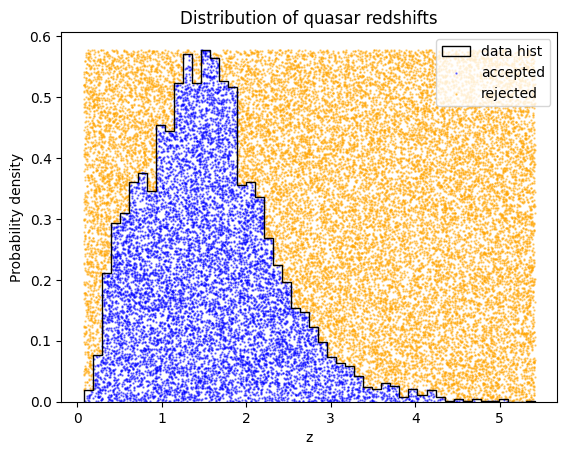

In [5]:
plt.hist(z, bins=bins,density=True, color='black', histtype='step', label='data hist')
plt.scatter(sampling_x,sampling_y, c = 'blue', marker = '.', s=2, alpha=0.5, label='accepted')
plt.scatter(rejected_x,rejected_y, c = 'orange', marker = '.', s=2, alpha=0.5, label='rejected')
plt.ylabel('Probability density')
plt.xlabel('z')
plt.title('Distribution of quasar redshifts')
plt.legend()

# Inverse transform

I want to upsample the quasar redshift distribution with **inverse transform sampling**. <br>
I want to generate $N=10^4$ points in total. <br>
First, from the distribution $h(x)$ I can compute its Cumulative Distribution Function (CDF) $H(x)$, and its inverse, the Quantile function $H^{-1}(x)$ <br>
To know what is the quantile function, I interpolate the CDF. <br>
Then, I generate random samples **u** from a uniform distribution $[0,1]$, and use the quantile function to find the value of X below which a fraction u of the distribution is contained.

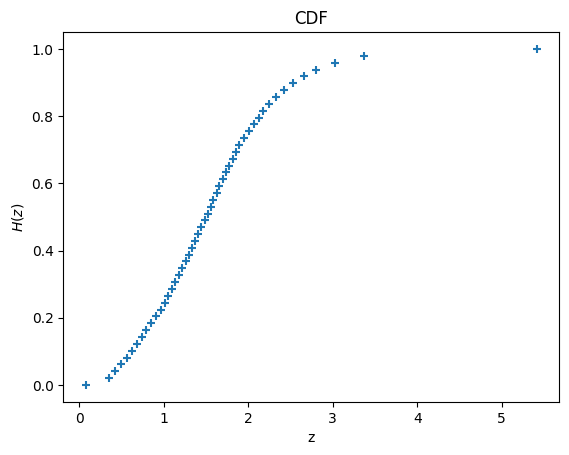

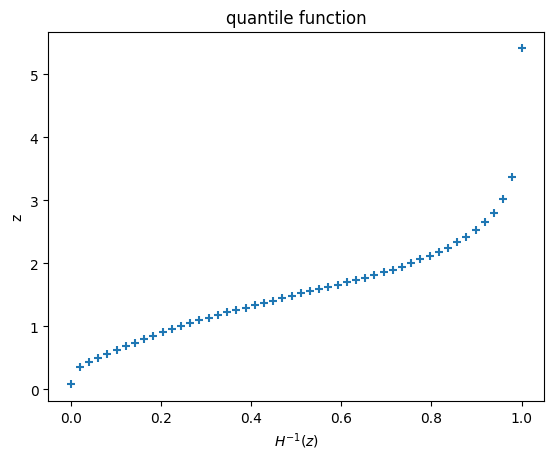

In [6]:
# Compute the CDF
z.sort()
index = np.linspace(0,len(z)-1, bins, dtype=int)
cdf   = np.linspace(0,1,len(z))
plt.scatter(z[index], cdf[index], marker='+')
plt.xlabel('z')
plt.ylabel(r'$H(z)$')
plt.title('CDF')
plt.show()

# Compute the quantile function
quantile = interpolate.interp1d(cdf, z)
plt.scatter(cdf[index], quantile(cdf[index]), marker='+')
plt.ylabel('z')
plt.xlabel(r'$H^{-1}(z)$')
plt.title('quantile function')
plt.show()

In [7]:
u = np.random.uniform(0,1, 10**4)
# X is my new upsampling distribution
X = np.array([quantile(u[i]) for i in range(len(u))])

I now can compare the three different distributions: the **data**, the **rejection sampling**, and the **inverse transorm sampling**.

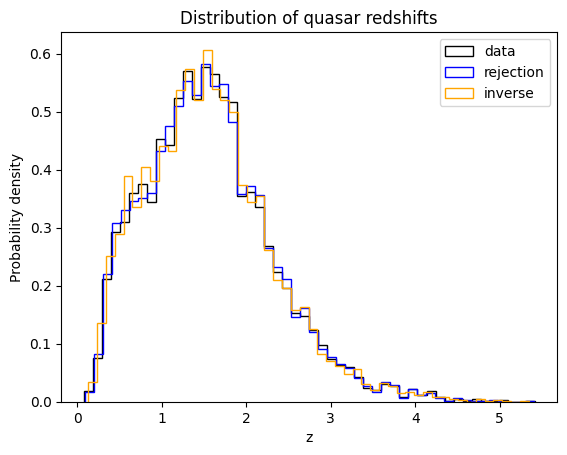

In [8]:
plt.hist(z, bins=bins,density=True, color='black', histtype='step', label='data')
plt.hist(sampling_x, bins=bins,density=True, color='blue', histtype='step', label='rejection')
plt.hist(X, bins=bins,density=True, color='orange', histtype='step', label='inverse')
plt.ylabel('Probability density')
plt.xlabel('z')
plt.title('Distribution of quasar redshifts')
plt.legend()
plt.show()

At least visually, they are similar.

To do another test and check if they are similar to the original ditribution or not.....*DO LATER*

# Cosmology of quasars

In [9]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name='Planck18', H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.30966, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.04897)

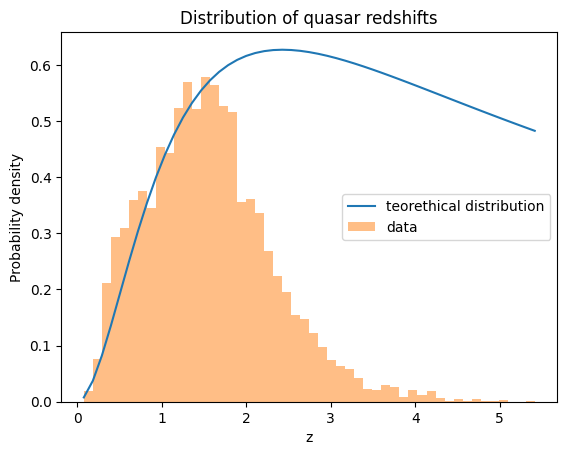

In [10]:
def theoretical_distribution(z):
    return 4 * np.pi * astropy.cosmology.Planck15.differential_comoving_volume(z)

# Arbitrarily normalized
plt.plot(matrice[1], 1.18*10e-13 * theoretical_distribution(matrice[1]), label='teorethical distribution')

plt.hist(z, bins=bins, density=True, alpha=0.5, label='data') 
plt.ylabel('Probability density')
plt.xlabel('z')
plt.title('Distribution of quasar redshifts')
plt.legend()
plt.show()

I observe that for small redshifts, the data follow the theoretical distribution. <br>
But, at high redshifts the data drift from theory. Probably, it is because we don't see all quasars at these redshifts due to selection effects in observations.